# 0. Imports

In [35]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import scikitplot as skplt
import pickle

from pathlib import Path
from matplotlib import pyplot as plt

from scipy import stats
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

# 0.1. Helper Functions

In [36]:
def precision_at_k (data, score, sample_perc = 0.5):
    
    # transform sample_perc into k-row value
    k = int(len(data) * sample_perc) # get corresponding row of the dataset

    # sort list by propensity score value
    data = data.sort_values(score, ascending = False)

    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1 # ranking number starts at 1

    # create precision_at_k column
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    # return precision value at k row
    return data.loc[k, 'precision_at_k']

def recall_at_k (data, score, sample_perc = 0.5):
    
    # transform sample_perc into k-row value
    k = int(len(data) * sample_perc) # get corresponding row of the dataset

    # sort list by propensity score value
    data = data.sort_values(score, ascending = False)

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1 # ranking number starts at 1

    # create recall_at_k column
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    # return recall value at k row
    return data.loc[k, 'recall_at_k']

def save_model(path, filename, model):

    path_ = str(Path.cwd().parents[0])
    path_ = path_ + path + '/' + filename
    pickle.dump(model, open(path_, 'wb'))

    return None

# 1. Data Preparation

In [37]:
# load data
path = str(Path.cwd().parents[0] / "data" / "processed")
path = path + '/' + 'df_eda.csv'

df = pd.read_csv(path)

In [38]:
# return variables to original values

# response
# driving_license
# vehicle_damage
# previously_insured

for i in df.columns:

    if (i == 'response') | (i == 'driving_license') | (i == 'vehicle_damage') | (i == 'previously_insured'):
        df[i] = df[i].apply(lambda x: 1 if x == 'Yes' else 0)
    
    else:
        pass

In [39]:
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,New,1,0,23367.0,249,0
1,13,Female,41,15,14,1,Average,0,1,31409.0,221,0
2,18,Female,25,35,152,1,New,0,1,46622.0,299,0
3,31,Female,26,8,160,1,New,0,0,2630.0,136,0
4,39,Male,45,8,124,1,Average,1,0,42297.0,264,0


In [40]:
# simulates production environment

X = df.drop('response', axis = 1) # real data does not contain response
y = df['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size = 0.20, random_state = 9) # spit dataset between train and test

df = pd.concat([x_train, y_train], axis = 1)

# save validation datasets - they will be used to test the API later
# save_model('/data/interim', 'x_validation.pkl', x_validation)
# save_model('/data/interim', 'y_validation.pkl', y_validation)


## Standardization
Only attributes with Normal distribution.

In [41]:
# annual_premium (we will not remove outliers now)

ss = pp.StandardScaler()

df['annual_premium'] = ss.fit_transform(df[['annual_premium']].values) # encoder receives an array

## Rescaling

In [42]:
# saves scaler to the same variable which will be used in the test
mms_age = pp.MinMaxScaler() 
mms_vintage = pp.MinMaxScaler()

# age
df['age'] = mms_age.fit_transform(df[['age']].values)

# vintage
df['vintage'] = mms_vintage.fit_transform(df[['vintage']].values)

## Encoding
Only categorical attributes which we want to mantain its nature (eg. binary, ordinal)

In [43]:
# gender
target_encode_gender = df.groupby('gender')['response'].mean()
df.loc[:,'gender'] = df['gender'].map(target_encode_gender)

# region_code - Frequency Encoding | Target Encoding (we choose this) | Weigthed Target Encoding
target_encode_region_code = df.groupby('region_code')['response'].mean()
df.loc[:,'region_code'] = df['region_code'].map(target_encode_region_code) # replace all values within policy_sales_channel column with encoded values

# vehicle_age - One Hot Encoding (we choose this) | Order Encoding
df = pd.get_dummies(df, prefix = 'vehicle_age', columns = ['vehicle_age'])

# policy_sales_channel - Target Encoding | Frequency Encoding (we choose this)
# Frequency Encoding gives more weight to more frequent values of the categorical attribute
fe_policy_sales_channel = df.groupby('policy_sales_channel').size() / len(df)
df.loc[:,'policy_sales_channel'] = df['policy_sales_channel'].map(fe_policy_sales_channel) # replace all values within policy_sales_channel column with encoded values


# Saving Encoders

In [44]:
# # saving encoders
# folder = '/src/features'

# filename = {
#     'annual_premium_scaler.pkl':ss,
#     'age_scaler.pkl':mms_age,
#     'vintage_scaler.pkl':mms_vintage,
#     'target_encoder_gender_scaler.pkl':target_encode_gender,
#     'target_encoder_region_code_scaler.pkl':target_encode_region_code,
#     'frequency_encoder_policy_sales_scaler.pkl':fe_policy_sales_channel
#     }


# for filename, scaler in filename.items():
#     save_model(folder, filename, scaler)

## Validation Preparation

In [45]:
# applies same training encoders to testing (validation, val) data

# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_validation.loc[:, 'vehicle_age'] = pd.get_dummies(x_validation, prefix = 'vehicle_age', columns = ['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

# 2. Feature Selection

## 2.1. Features Importance

In [46]:
# # model definition
# forest = en.ExtraTreesClassifier(n_estimators = 250, random_state = 0, n_jobs = -2) # n_jobs will not use all cores

# # data preparation
# x_train_n = df.drop(['id', 'response'], axis = 1)
# y_train_n = y_train.values
# forest.fit(x_train_n, y_train_n)

In [47]:
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
# indices = np.argsort(importances)[::-1]

# # Print feature ranking
# print('Feature Ranking:')
# data = pd.DataFrame()
# for i, j in zip(x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature': i, 'importance': j}, index = [0])
#     data = pd.concat([data, aux], axis = 0)

# print(data.sort_values('importance', ascending = False))

# # Plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title('Feature Importances')
# plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'r', yerr = std[indices], align = 'center')
# plt.xticks(range(x_train_n.shape[1]), indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show()


# 3. Machine Learning

In [48]:
# arbitrary selection
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

In [49]:
# using only the selected features to train and test (validation) the model
x_train = df[cols_selected]
x_val = x_validation[cols_selected]

## 3.1. KNN

' What this chart tell?\nif i make the offer to 40% of the ordered list, i will find ~85% of interested people (with 07 neighbors)\nthis means the KNN model left interested people on the end of the list\nmore KNN Neighbors = i will find more interested people'

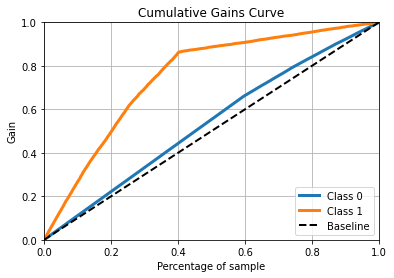

In [16]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_knn = knn_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn);

""" What this chart tell?
if i make the offer to 40% of the ordered list, i will find ~85% of interested people (with 07 neighbors)
this means the KNN model left interested people on the end of the list
more KNN Neighbors = i will find more interested people"""

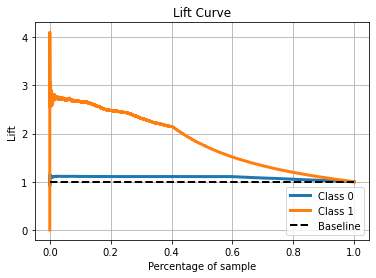

In [17]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_knn);

## 3.2. Linear Regression

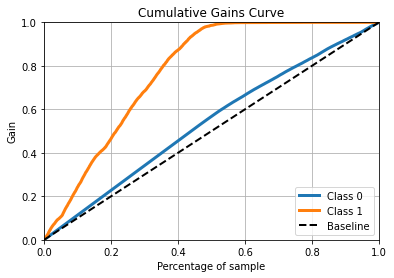

In [18]:
# model definition
lr_model = lm.LogisticRegression(random_state = 42)

# model training
lr_model.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_lr = lr_model.predict_proba(x_val)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr);

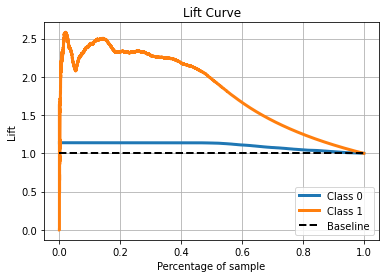

In [19]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lr);

## 3.3. Extra Trees

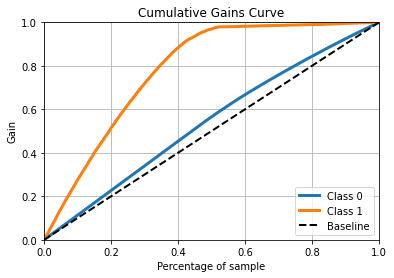

In [20]:
# model definition
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)

# model training
et.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_et = et.predict_proba(x_val)

skplt.metrics.plot_cumulative_gain(y_validation, yhat_et);

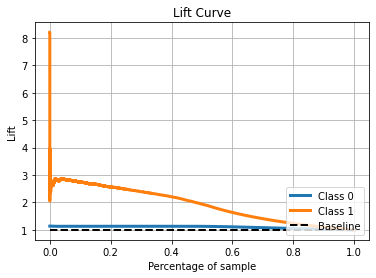

In [21]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_et);

## 3.4. Random Forest

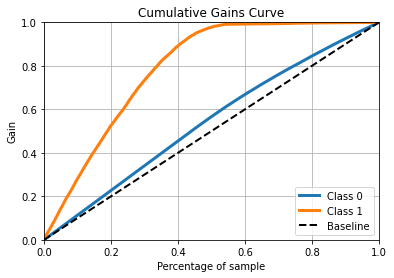

In [22]:
# model definition
rf = en.RandomForestClassifier(n_estimators = 100, n_jobs = -2, random_state = 42)

# model training
rf.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_rf = rf.predict_proba(x_val)

# Cumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_rf);

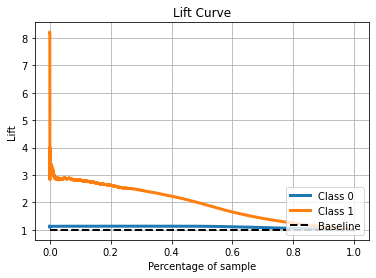

In [23]:
# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_rf);

# 4. Model Performance

## 4.1. Holdout Validation

In [58]:
# copy data
df_perf = x_validation.copy()
df_perf['response'] = y_validation.copy()

# propensity score - from KNN Model
# yhat = Prediction probabilities for each class returned by a classifier.
df_perf['score_knn'] = yhat_knn[:,1].tolist() # get all propensity score values of response = 1 then converts to list
# yhat is an array resulted from predict_proba methods. This result shows class probabilities which classes in lexicographical order
# source: https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09b/sklearn/neighbors/_classification.py#L240
# In this specific case, the class on position '1' is the response '1'.

# propensity score - from Linear Regression Model
df_perf['score_lr'] = yhat_lr[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# propensity score - from Extra Trees Model
df_perf['score_et'] = yhat_et[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# propensity score - from Random Forest Model
df_perf['score_rf'] = yhat_rf[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# models to evaluate
scores = ['score_knn', 'score_lr', 'score_et', 'score_rf']

# create list to store performance metrics
performance = []

k = 0.4 # sample percentage

for i in scores:
    # compute Precision at k (Precision Top K) = ratio of True Positives within all Positives?
    precision = precision_at_k(df_perf, i, k)

    # compute Recall at k = ratio of True Positives within all instances of the dataset
    recall = recall_at_k(df_perf, i, k)

    # save performance metrics
    performance.append([i, precision, recall, k])

# convert performance metrics list to dataframe
df_perf_rank = pd.DataFrame(performance, columns = ['model', 'precision', 'recall', 'k%'])
df_perf_rank['k%'] = df_perf_rank['k%'] * 100
df_perf_rank = df_perf_rank.round(decimals = {'precision' : 4, 'recall' : 4 , 'k%' : 0}).sort_values('recall', ascending = False).reset_index(drop=True)

In [59]:
df_perf_rank

,model,precision,recall,k%
0,score_rf,0.2718,0.8921,40.0
1,score_et,0.2696,0.8848,40.0
2,score_lr,0.2659,0.8726,40.0
3,score_knn,0.2616,0.8587,40.0


## 4.2. K-Fold Cross Validation

In [55]:
kf = ms.KFold(n_splits = 5)

# model definition
lr_model = lm.LogisticRegression(random_state = 42)

i = 'score_lr'

k = 0.4

performance = []

for train, test in kf.split(x_train, y_train): # returns an array of train and test indexes
    #print('TRAIN: ', train_index, 'TEST: ', test_index)  

    df_perf = x_train.iloc[test].copy()
    df_perf['response'] = y_train.iloc[test].copy()

    # model training
    lr_model.fit(x_train.iloc[train], y_train.iloc[train])

    # model prediction - Generalizing Power
    yhat_lr = lr_model.predict_proba(x_train.iloc[test])

    # propensity score - from Linear Regression Model
    df_perf[i] = yhat_lr[:,1].tolist() # get all propensity score values of response = 1 then converts to list

    # compute Precision at k (Precision Top K) = ratio of True Positives within all Positives?
    precision = precision_at_k(df_perf, i, k)

    # compute Recall at k = ratio of True Positives within all instances of the dataset
    recall = recall_at_k(df_perf, i, k)

    # save performance metrics
    performance.append([i, precision, recall, k])

performance

    # 1. instanciar modelo
    # 2. treinar modelo
    # 3. testar modelo
    # 4. criar coluna nova 'score_modelo'
    # 5. chamar precision_at_k e recall_at_k
    # 6. armazenar precision e recall daquele modelo
    # 7. repetir passos 2-6 até percorrer todos os índices informados pelo ms.KFold
    # 8. calcular a média e desvio padrão dos valores de precision e recall armazenados daquele modelo
    # 9. retornar: nome do modelo, kfolds, k, média do precision, std precision, média recall, std recall
    # 10. repetir passos 1-9 até terminar todos os modelos que queremos fazer cross-validation
    


[['score_lr', 0.26906362741882583, 0.8777584592751103, 0.4],
 ['score_lr', 0.2652509019350607, 0.8734980423923315, 0.4],
 ['score_lr', 0.26792669427247756, 0.8639608672659969, 0.4],
 ['score_lr', 0.26661473494321675, 0.8712486602357985, 0.4],
 ['score_lr', 0.26591775654954697, 0.8663015894216642, 0.4]]

In [72]:
rank = pd.DataFrame(performance, columns = ['model', 'precision', 'recall', 'k%'])
rank['k%'] = rank['k%'] * 100
# rank = rank.round(decimals = {'precision' : 4, 'recall' : 4 , 'k%' : 0}).sort_values('recall', ascending = False).reset_index(drop=True)

# print('Recall Mean is: ', format(rank['recall'].mean()))
# print('Recall Standard Deviation is: ', format(rank['recall'].std()))
# print('Recall is: {}'.format(round(rank['recall'].mean(), 4)) + ' +/- ' + '{}'.format(round(2*rank['recall'].std(), 4)))

k_folds = 5
perf_metrics = []
precision_mean = round(rank['precision'].mean(), 4)
precision_std = round(rank['precision'].std(), 4)
recall_mean = round(rank['recall'].mean(), 4)
recall_std = round(rank['recall'].std(), 4)
perf_metrics.append([i, k_folds, k, precision_mean, precision_std, recall_mean, recall_std])

perf_metrics
perf_metrics_df = pd.DataFrame(perf_metrics, columns = ['model', 'k_folds', 'k', 'precision_at_k_mean', 'precision_at_k_std', 'recall_at_k_mean', 'recall_at_k_std'])
perf_metrics_df


,model,k_folds,k,precision_at_k_mean,precision_at_k_std,recall_at_k_mean,recall_at_k_std
0,score_lr,5,0.4,0.267,0.0015,0.8706,0.0055


# 5.0 Saving Models

#

In [51]:
folder = '/src/models'

models_names = {
    'model_knn.pkl':knn_model, 
    'model_linear_regression.pkl':lr_model, 
    'model_extra_trees.pkl':et,
    'model_random_forest.pkl':rf
    }

for filename, model in models_names.items():
    save_model(folder, filename, model)